# French Motor Claims Datasets

This analysis uses the same features as in the book "Computational Actuarial Science with R" by Arthur Charpentier.

Charpentier Arthur and Katrien Antonio. 2015. Computational Actuarial Science with R. Boca Raton Florida: CRC Press.

In [1]:
import pandas as pd
import tarfile
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from stabletrees import BaseLineTree,AbuTreeI,NaiveUpdate,TreeReevaluation,StabilityRegularization, BABUTree
from sklearn.tree import DecisionTreeRegressor
SEED = 0
plt.rcParams["figure.figsize"] = (20,12)

In [2]:
path = "..\data\poisson"
for file in os.listdir(path):
    if file.endswith('.csv'):
        name = file.split(".")[0]
        print(name)
        if name == "norauto":
            tar = tarfile.open(path+"//"+name+".tar.gz", "w:gz")
            tar.add(path+"//"+file)
            tar.close()

norauto


In [3]:
with tarfile.open("..\data\poisson\\freMTPLfreq.tar.gz", "r:*") as tar:
    csv_path = tar.getnames()[0]
    df = pd.read_csv(tar.extractfile(csv_path), header=0)

In [4]:
df.head()

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density
0,1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76
1,2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76
2,3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003
3,4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003
4,5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60


In [5]:
df["y"] =df.ClaimNb * df.Exposure #annulized claim frequency (see p.480 in computational actuarial science with R)

ClaimNb = df.ClaimNb.to_numpy()
Exposure = df.Exposure.to_numpy()
df.drop(["PolicyID","Exposure","ClaimNb"],axis=1,inplace=True)


## Density
The density of inhabitants (number of inhabitants per km2) in the city the driver of the car lives in.

In [6]:
df.Density = pd.cut(df.Density, include_lowest=True, bins=[0,40,200,500,4500,np.inf])

## DrivAge
The driver age, in years (in France, people can drive a car at 18).

In [7]:
df.DriverAge  = pd.cut(df.DriverAge , bins=[17,22,26,42,74,np.inf])

## VehAge 
The vehicle age, in years.

In [8]:
df.CarAge  = pd.cut(df.CarAge, include_lowest=True , bins=[0,15,np.inf])

## Brand


In [9]:
df["brandF"] = np.where(df.Brand=="Japanese (except Nissan) or Korean","F","other")

## Power

In [10]:
df["Power"] = ["DEF" if p in ["d","e","f"] else "other" if p in ["d","e","f"] else "GH" for p in df.Power ]

In [11]:
df.insert(len(df.columns)-1, 'y', df.pop('y'))

In [12]:
tree_preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            OrdinalEncoder(),
            ["CarAge", "DriverAge", "Gas", "Density"],
        ),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["Power", "brandF"],
        ),
        ("numeric", "passthrough", ["y"]),
    ],
    remainder="drop",
)

In [13]:
df_prep = tree_preprocessor.fit_transform(df)
X = df_prep[:,:-1]
y = df_prep[:,-1]
y = y

In [14]:
t = BaseLineTree(criterion="poisson",adaptive_complexity=True).fit(X,y)
mask = ClaimNb!=0
mean_poisson_deviance(ClaimNb,t.predict(X)*Exposure)


0.2745897654125622

In [15]:
from sklearn.linear_model import PoissonRegressor
lm = PoissonRegressor(alpha=0.001).fit(X,y)
mask = ClaimNb!=0
mean_poisson_deviance(ClaimNb,lm.predict(X)*Exposure)



0.27981742095821643

In [16]:
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold
EPSILON = 1.1

def S1(pred1, pred2):
    return np.std(np.log((pred2+EPSILON)/(pred1+EPSILON)))

def S2(pred1, pred2):
    return np.mean((pred1- pred2)**2)

In [17]:
models = {  
            "baseline": BaseLineTree(),
            "sklearn": DecisionTreeRegressor(),
            "poisReg": PoissonRegressor(alpha=0.001),
            "NU": NaiveUpdate(),
            "TR":TreeReevaluation(delta=0.1),
            "SR":StabilityRegularization(),
            "ABU":AbuTreeI(),
            "BABU": BABUTree()
            }
stability_all = {name:[] for name in models.keys()}
standard_stability_all= {name:[] for name in models.keys()}
mse_all= {name:[] for name in models.keys()}

stability = {name:[] for name in models.keys()}
standard_stability = {name:[] for name in models.keys()}
mse = {name:[] for name in models.keys()}
train_stability = {name:[] for name in models.keys()}
train_standard_stability = {name:[] for name in models.keys()}
train_mse = {name:[] for name in models.keys()}
orig_stability = {name:[] for name in models.keys()}
orig_standard_stability = {name:[] for name in models.keys()}
orig_mse = {name:[] for name in models.keys()}
parameters = {'max_depth':[None, 5, 10],"min_samples_leaf": [5]} # , 
#clf = GridSearchCV(DecisionTreeRegressor(random_state=0, criterion="poisson"), parameters)
kf = RepeatedKFold(n_splits= 5,n_repeats=10, random_state=SEED)
for train_index, test_index in kf.split(X):
    X_12, y_12 = X[train_index],y[train_index]
    ClaimNb_12 = ClaimNb[train_index]
    Exposure_12  = Exposure[train_index]
    X_test,y_test = X[test_index],y[test_index]
    ClaimNb_test = ClaimNb[test_index]
    Exposure_test  = Exposure[test_index]
    X1,X2,y1,y2,ClaimNb_1,ClaimNb_2,Exposure_1,Exposure_2 =  train_test_split(X_12, y_12,ClaimNb_12,Exposure_12, test_size=0.5, random_state=SEED)
    # clf.fit(X1,y1)
    # params = clf.best_params_
    # initial model 
    criterion = "poisson"
    models = {  
            "baseline": BaseLineTree(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "sklearn": DecisionTreeRegressor(criterion = criterion, max_depth=5, min_samples_leaf=5),
            "poisReg": PoissonRegressor(alpha=0.001),
            "NU": NaiveUpdate(criterion = criterion, adaptive_complexity=True),
            "TR":TreeReevaluation(criterion = criterion, adaptive_complexity=True, delta=0.1),
            "SR":StabilityRegularization(criterion = criterion, adaptive_complexity=True,lmbda=0.75),
            "ABU":AbuTreeI(criterion = criterion, adaptive_complexity=True),
            "BABU": BABUTree(criterion = criterion, adaptive_complexity=True),

            }
    for name, model in models.items():
        model.fit(X1,y1)
        
        pred1 = model.predict(X_test) 
        pred1_train = model.predict(X_12)
        pred1_orig= model.predict(X1)
        #print("before")
        if name == "poisReg":
            model.fit(X_12,y_12)
        elif name == "sklearn":
            model.fit(X_12,y_12)
        else:
            model.update(X_12,y_12)
        #print("after")
        pred2 = model.predict(X_test) 
        pred2_orig= model.predict(X1) 
        pred2_train =  model.predict(X_12)
        orig_mse[name].append(mean_poisson_deviance(ClaimNb_1+0.00001,pred2_orig*Exposure_1+0.00001))
        orig_stability[name].append(S1(pred1_orig*Exposure_1,pred2_orig*Exposure_1))
        orig_standard_stability[name].append(S2(pred1_orig*Exposure_1,pred2_orig*Exposure_1))

        train_mse[name].append(mean_poisson_deviance(ClaimNb_12+0.00001,pred2_train*Exposure_12+0.00001))
        train_stability[name].append(S1(pred1_train*Exposure_12,pred2_train*Exposure_12))
        train_standard_stability[name].append(S2(pred1_train*Exposure_12,pred2_train*Exposure_12))
        mse[name].append(mean_poisson_deviance(ClaimNb_test+0.00001,pred2*Exposure_test+0.00001))
        stability[name].append(S1(pred1*Exposure_test,pred2*Exposure_test))
        standard_stability[name].append(S2(pred1*Exposure_test,pred2*Exposure_test))
    
for name in models.keys():
    print("="*80)
    print(f"{name}")
    orig_mse_scale = np.mean(orig_mse["baseline"]); orig_S1_scale = np.mean(orig_stability["baseline"]); orig_S2_scale = np.mean(orig_standard_stability["baseline"]);
    train_mse_scale = np.mean(train_mse["baseline"]); train_S1_scale = np.mean(train_stability["baseline"]); train_S2_scale = np.mean(train_standard_stability["baseline"]);
    mse_scale = np.mean(mse["baseline"]); S1_scale = np.mean(stability["baseline"]); S2_scale = np.mean(standard_stability["baseline"]);
    
    print(f"orig - poisson: {np.mean(orig_mse[name]):.3f} ({np.mean(orig_mse[name])/orig_mse_scale:.2f}), stability: {np.mean(orig_stability[name]):.3f} ({np.mean(orig_stability[name])/orig_S1_scale:.2f}), standard stability: {np.mean(orig_standard_stability[name]):.3f} ({np.mean(orig_standard_stability[name])/orig_S2_scale:.2f})")
    print(f"train - poisson: {np.mean(train_mse[name]):.3f} ({np.mean(train_mse[name])/train_mse_scale:.2f}), stability: {np.mean(train_stability[name]):.3f} ({np.mean(train_stability[name])/train_S1_scale:.2f}), standard stability: {np.mean(train_standard_stability[name]):.3f} ({np.mean(train_standard_stability[name])/train_S2_scale:.2f})")
    print(f"test - poisson: {np.mean(mse[name]):.3f} ({np.mean(mse[name])/mse_scale:.2f}), stability: {np.mean(stability[name]):.3f} ({np.mean(stability[name])/S1_scale:.2f}), standard stability: {np.mean(standard_stability[name]):.3f} ({np.mean(standard_stability[name])/S2_scale:.2f})")
    print("="*80)
    mse_all[name] += [score/mse_scale for score in mse[name]]
    stability_all[name] += [score/S1_scale for score in stability[name]]
    standard_stability_all[name] += [score/S2_scale for score in standard_stability[name]]
print()

baseline
orig - poisson: 0.275 (1.00), stability: 0.002 (1.00), standard stability: 0.000 (1.00)
train - poisson: 0.275 (1.00), stability: 0.002 (1.00), standard stability: 0.000 (1.00)
test - poisson: 0.275 (1.00), stability: 0.002 (1.00), standard stability: 0.000 (1.00)
sklearn
orig - poisson: 0.280 (1.02), stability: 0.001 (0.65), standard stability: 0.000 (0.39)
train - poisson: 0.280 (1.02), stability: 0.001 (0.65), standard stability: 0.000 (0.38)
test - poisson: 0.280 (1.02), stability: 0.001 (0.65), standard stability: 0.000 (0.37)
poisReg
orig - poisson: 0.280 (1.02), stability: 0.000 (0.18), standard stability: 0.000 (0.03)
train - poisson: 0.280 (1.02), stability: 0.000 (0.18), standard stability: 0.000 (0.03)
test - poisson: 0.280 (1.02), stability: 0.000 (0.18), standard stability: 0.000 (0.03)
NU
orig - poisson: 0.277 (1.01), stability: 0.002 (0.87), standard stability: 0.000 (63.03)
train - poisson: 0.277 (1.01), stability: 0.002 (0.86), standard stability: 0.000 (61.01

In [18]:
with tarfile.open("..\data\poisson\\norauto.tar.gz", "r:*") as tar:
    csv_path = tar.getnames()[0]
    df = pd.read_csv(tar.extractfile(csv_path), header=0)

In [19]:
df.head()

,Male,Young,DistLimit,GeoRegion,Expo,ClaimAmount,NbClaim
0,0,0,12000 km,Low+,0.789,0.0,0
1,0,1,12000 km,Medium+,0.200,0.0,0
2,0,1,25000-30000 km,Medium+,0.285,0.0,0
3,0,0,12000 km,Medium-,0.247,0.0,0
4,0,0,12000 km,High-,0.995,18158.0,1


## distLimit
The distance limit as stated in the insurance contract: "8000 km", "12000 km", "16000 km", "20000 km", "25000-30000 km", "no limit".

In [20]:
df["DistLimit_ints"] = pd.Categorical(df.DistLimit, categories=["8000 km", "12000 km", "16000 km", "20000 km","25000-30000 km", "no limit"], ordered=True).rename_categories(np.arange(6))

## GeoRegion
GeoRegion Density of the geographical region (from heaviest to lightest): "High+", "High-", "Medium+", "Medium-", "Low+", "Low-".

In [21]:
np.unique(df.GeoRegion)

array(['High+', 'High-', 'Low+', 'Low-', 'Medium+', 'Medium-'],
      dtype=object)

In [22]:
df["GeoRegion_ints"] = pd.Categorical(df.GeoRegion, categories=['Low-','Low+','Medium-', 'Medium+', 'High-','High+'], ordered=True).rename_categories(np.arange(6))

In [23]:
df

,Male,Young,DistLimit,GeoRegion,Expo,ClaimAmount,NbClaim,DistLimit_ints,GeoRegion_ints
0,0,0,12000 km,Low+,0.789,0.0,0,1,1
1,0,1,12000 km,Medium+,0.200,0.0,0,1,3
2,0,1,25000-30000 km,Medium+,0.285,0.0,0,4,3
3,0,0,12000 km,Medium-,0.247,0.0,0,1,2
4,0,0,12000 km,High-,0.995,18158.0,1,1,4
...,...,...,...,...,...,...,...,...,...
183994,1,0,no limit,High-,0.430,0.0,0,5,4
183995,1,0,no limit,High+,0.718,27807.0,1,5,5
183996,1,0,25000-30000 km,High-,0.362,0.0,0,4,4
183997,1,0,25000-30000 km,High-,0.764,0.0,0,4,4


In [24]:
df["y"] = df.NbClaim/df.Expo

In [25]:
df.insert(len(df.columns)-1, 'y', df.pop('y'))

In [26]:
ClaimNb = df.NbClaim.to_numpy()
Exposure = df.Expo.to_numpy()
df.drop(["DistLimit","GeoRegion","ClaimAmount","Expo","NbClaim"],axis=1,inplace=True)

In [27]:
df

,Male,Young,DistLimit_ints,GeoRegion_ints,y
0,0,0,1,1,0.000000
1,0,1,1,3,0.000000
2,0,1,4,3,0.000000
3,0,0,1,2,0.000000
4,0,0,1,4,1.005025
...,...,...,...,...,...
183994,1,0,5,4,0.000000
183995,1,0,5,5,1.392758
183996,1,0,4,4,0.000000
183997,1,0,4,4,0.000000


In [28]:
X = df.to_numpy()[:,:-1]
y = df.to_numpy()[:,-1]

In [29]:
lm = PoissonRegressor(alpha=0.001).fit(X,y)
mean_poisson_deviance(ClaimNb,lm.predict(X)*Exposure)

0.27006646122057276

In [30]:
t = BaseLineTree(criterion="poisson",adaptive_complexity=True).fit(X,y)
mean_poisson_deviance(ClaimNb,t.predict(X)*Exposure)


0.2709736255375587

In [31]:
t = StabilityRegularization(criterion = "poisson", adaptive_complexity=True,lmbda=0.75).fit(X,y)
t.update(X,y)
mean_poisson_deviance(ClaimNb,t.predict(X)*Exposure)

0.27097362553755866

In [32]:
models = {  
            "baseline": BaseLineTree(),
            "poisReg": PoissonRegressor(alpha=0.001),
            "NU": NaiveUpdate(),
            "TR":TreeReevaluation(delta=0.1),
            "SR":StabilityRegularization(),
            "ABU":AbuTreeI(),
            "BABU": BABUTree()
            }
stability_all = {name:[] for name in models.keys()}
standard_stability_all= {name:[] for name in models.keys()}
mse_all= {name:[] for name in models.keys()}

stability = {name:[] for name in models.keys()}
standard_stability = {name:[] for name in models.keys()}
mse = {name:[] for name in models.keys()}
train_stability = {name:[] for name in models.keys()}
train_standard_stability = {name:[] for name in models.keys()}
train_mse = {name:[] for name in models.keys()}
orig_stability = {name:[] for name in models.keys()}
orig_standard_stability = {name:[] for name in models.keys()}
orig_mse = {name:[] for name in models.keys()}
kf = RepeatedKFold(n_splits= 5,n_repeats=10, random_state=SEED)
for train_index, test_index in kf.split(X):
    X_12, y_12 = X[train_index],y[train_index]
    ClaimNb_12 = ClaimNb[train_index]
    Exposure_12  = Exposure[train_index]
    X_test,y_test = X[test_index],y[test_index]
    ClaimNb_test = ClaimNb[test_index]
    Exposure_test  = Exposure[test_index]
    X1,X2,y1,y2,ClaimNb_1,ClaimNb_2,Exposure_1,Exposure_2 =  train_test_split(X_12, y_12,ClaimNb_12,Exposure_12, test_size=0.5, random_state=SEED)
   
    # initial model 
    criterion = "poisson"
    models = {  
            "baseline": BaseLineTree(criterion = criterion, adaptive_complexity=True),
            "poisReg": PoissonRegressor(alpha=0.001),
            "NU": NaiveUpdate(criterion = criterion, adaptive_complexity=True),
            "TR":TreeReevaluation(criterion = criterion, adaptive_complexity=True, delta=0.1),
            "SR":StabilityRegularization(criterion = criterion, adaptive_complexity=True,lmbda=0.75),
            "ABU":AbuTreeI(criterion = criterion, adaptive_complexity=True),
            "BABU": BABUTree(criterion = criterion, adaptive_complexity=True),

            }
    for name, model in models.items():
        model.fit(X1,y1)
        
        pred1 = model.predict(X_test)
        pred1_train = model.predict(X_12)
        pred1_orig= model.predict(X1)
        #print("before")
        
            
        if name == "poisReg":
            model.fit(X_12,y_12)
        else:
            model.update(X_12,y_12)
        #print("after")
        pred2 = model.predict(X_test)
        pred2_orig= model.predict(X1)
        pred2_train =  model.predict(X_12)
        if name == "SR": # if np.any(np.isnan(pred2_orig)  )or np.any(np.isinf(pred2_orig)  ):
            print(np.mean(y1), np.mean(y_12), np.mean(y_test))
        orig_mse[name].append(mean_poisson_deviance(ClaimNb_1+0.00001,pred2_orig*Exposure_1+0.00001))
        orig_stability[name].append(S1(pred1_orig*Exposure_1,pred2_orig*Exposure_1))
        orig_standard_stability[name].append(S2(pred1_orig*Exposure_1,pred2_orig*Exposure_1))

        train_mse[name].append(mean_poisson_deviance(ClaimNb_12+0.00001,pred2_train*Exposure_12+0.00001))
        train_stability[name].append(S1(pred1_train*Exposure_12,pred2_train*Exposure_12))
        train_standard_stability[name].append(S2(pred1_train*Exposure_12,pred2_train*Exposure_12))
        mse[name].append(mean_poisson_deviance(ClaimNb_test+0.00001,pred2*Exposure_test+0.00001))
        stability[name].append(S1(pred1*Exposure_test,pred2*Exposure_test))
        standard_stability[name].append(S2(pred1*Exposure_test,pred2*Exposure_test))
    
for name in models.keys():
    print("="*80)
    print(f"{name}")
    orig_mse_scale = np.mean(orig_mse["baseline"]); orig_S1_scale = np.mean(orig_stability["baseline"]); orig_S2_scale = np.mean(orig_standard_stability["baseline"]);
    train_mse_scale = np.mean(train_mse["baseline"]); train_S1_scale = np.mean(train_stability["baseline"]); train_S2_scale = np.mean(train_standard_stability["baseline"]);
    mse_scale = np.mean(mse["baseline"]); S1_scale = np.mean(stability["baseline"]); S2_scale = np.mean(standard_stability["baseline"]);
    
    print(f"orig - poisson: {np.mean(orig_mse[name]):.3f} ({np.mean(orig_mse[name])/orig_mse_scale:.2f}), stability: {np.mean(orig_stability[name]):.3f} ({np.mean(orig_stability[name])/orig_S1_scale:.2f}), standard stability: {np.mean(orig_standard_stability[name]):.3f} ({np.mean(orig_standard_stability[name])/orig_S2_scale:.2f})")
    print(f"train - poisson: {np.mean(train_mse[name]):.3f} ({np.mean(train_mse[name])/train_mse_scale:.2f}), stability: {np.mean(train_stability[name]):.3f} ({np.mean(train_stability[name])/train_S1_scale:.2f}), standard stability: {np.mean(train_standard_stability[name]):.3f} ({np.mean(train_standard_stability[name])/train_S2_scale:.2f})")
    print(f"test - poisson: {np.mean(mse[name]):.3f} ({np.mean(mse[name])/mse_scale:.2f}), stability: {np.mean(stability[name]):.3f} ({np.mean(stability[name])/S1_scale:.2f}), standard stability: {np.mean(standard_stability[name]):.3f} ({np.mean(standard_stability[name])/S2_scale:.2f})")
    print("="*80)
    mse_all[name] += [score/mse_scale for score in mse[name]]
    stability_all[name] += [score/S1_scale for score in stability[name]]
    standard_stability_all[name] += [score/S2_scale for score in standard_stability[name]]
print()

0.07236579585294962 0.07244842750596137 0.06938171954509159
0.07089445159565323 0.0713608112040344 0.07373215519800867
0.07213165658914837 0.07202774682041228 0.07106443085574757
0.07242855885897236 0.07163584835400687 0.07263201407195437
0.07182415399539017 0.07170257991770056 0.07236510763400791
0.07201724665770039 0.07178960727362038 0.07201698257173185
0.07344811847574875 0.07214916785558138 0.07057875001455577
0.07288589752266866 0.07208077011408366 0.07085233912191241
0.07066565599255317 0.07132253477840812 0.07388525986039346
0.0720854931635658 0.07183333289214838 0.07184208152355057
0.07097240259668117 0.07141237241392806 0.07352591175955392
0.07153520650148612 0.07185885959204032 0.07173997517990861
0.07225048468405548 0.0716983350229261 0.07238206909428484
0.07254811380582032 0.07223283611164623 0.07024407926389038
0.07214614090842089 0.07197300882440943 0.0712833626119272
0.07300112140358092 0.07176996604531646 0.0720955469512185
0.0721537391320823 0.0714407229216666 0.07341

In [33]:
x = np.array([[0,0],[0,1],[1,1],[1,1],[1,1]])
y = np.array([0,0,2,2,3])
x

array([[0, 0],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1]])

In [34]:
t = DecisionTreeRegressor(criterion="poisson").fit(x,y)
t.predict(x)

array([1.4, 1.4, 1.4, 1.4, 1.4])

[Text(167.4, 108.72, 'poisson = 0.743\nsamples = 5\nvalue = 1.4')]

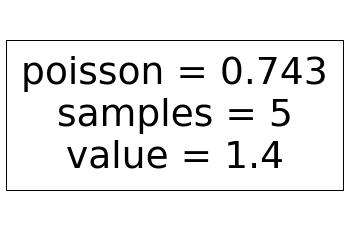

In [35]:
from sklearn.tree import plot_tree
plot_tree(t)

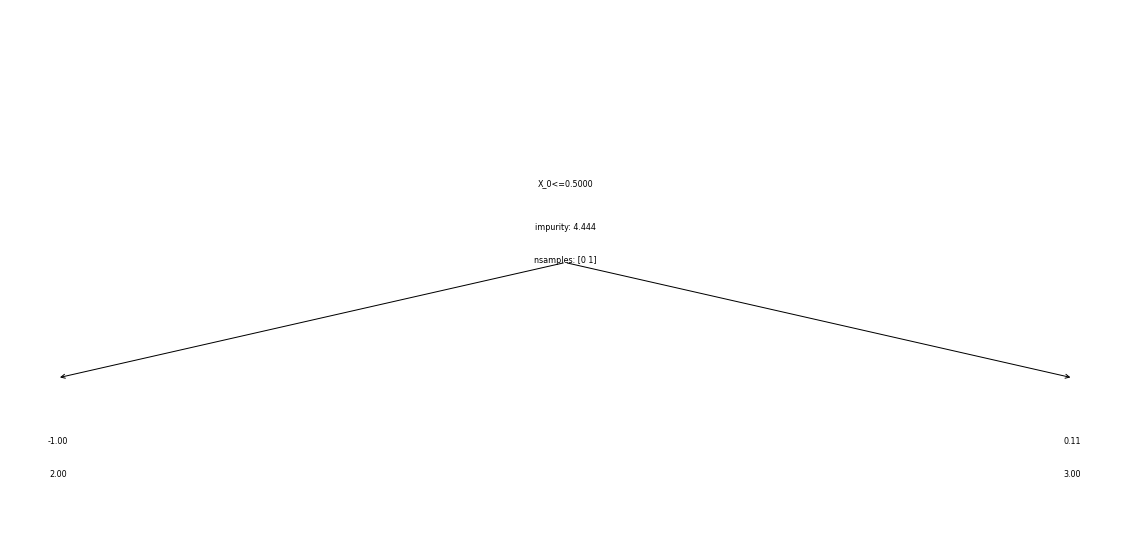

In [36]:
t = AbuTreeI(criterion="poisson",min_samples_leaf=1).fit(x,y)
t.plot()

In [ ]:
t.predict(x)

: 

: 

In [ ]:
np.exp(-0.8+np.mean(y))

2.718281828459045